In [11]:
# In a notebook cell:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import shap

In [12]:
# 1. Load
# from pathlib import Path
# DATA_DIR = Path(__file__).parent / "data"
df = pd.read_csv("/content/Fraud.csv")



# 2. Shape
print("Shape (rows, cols):", df.shape)

# 3. Class balance
print("\nFraud vs Non‑Fraud proportions:")
print(df['isFraud'].value_counts(normalize=True))

# 4. Missingness
print("\nMissing values per column:")
print(df.isna().sum())

# 5. Peek
print("\nFirst 5 rows:")
print(df.head())

Shape (rows, cols): (1414781, 11)

Fraud vs Non‑Fraud proportions:
isFraud
0.0    0.998887
1.0    0.001113
Name: proportion, dtype: float64

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0    

In [13]:
# Transaction type summary
type_summary = df.groupby('type').agg(
    total_transactions=('isFraud', 'count'),
    fraud_transactions=('isFraud', 'sum')
)
type_summary['fraud_rate'] = type_summary['fraud_transactions'] / type_summary['total_transactions']
print(type_summary)



          total_transactions  fraud_transactions  fraud_rate
type                                                        
CASH_IN               310329                 0.0    0.000000
CASH_OUT              506507               794.0    0.001568
DEBIT                   9298                 0.0    0.000000
PAYMENT               471499                 0.0    0.000000
TRANSFER              117147               780.0    0.006658


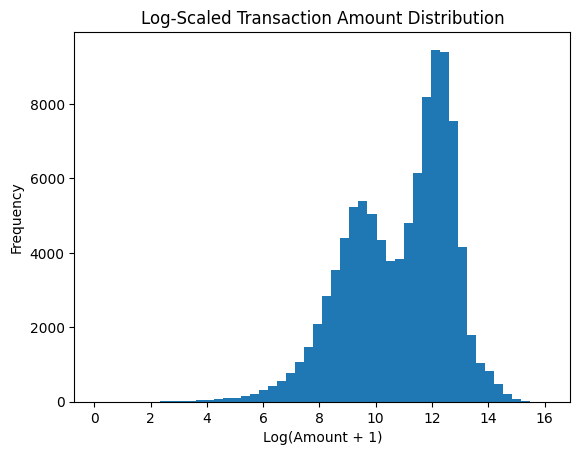

In [14]:

# (Optional) sample 100k rows for faster plotting
sample_amt = df['amount'].sample(n=100_000, random_state=42) if len(df) > 100_000 else df['amount']

plt.figure()
plt.hist(np.log1p(sample_amt), bins=50)
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')
plt.title('Log‑Scaled Transaction Amount Distribution')
plt.show()


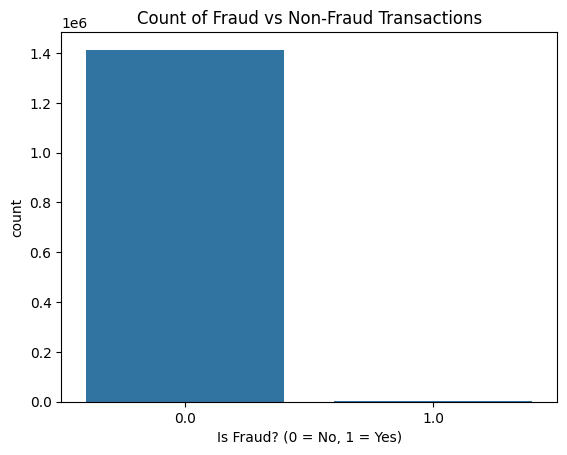

In [15]:
sns.countplot(x='isFraud', data=df)
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.title('Count of Fraud vs Non‑Fraud Transactions')
plt.show()


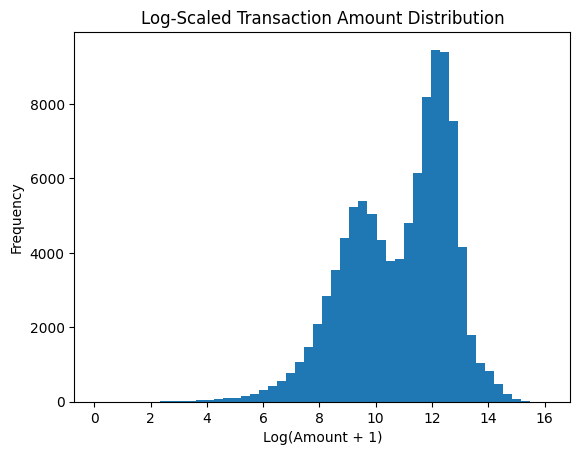

In [16]:
# 1. Log‑scaled amount histogram
sample_amt = df['amount'].sample(n=100_000, random_state=42) \
             if len(df) > 100_000 else df['amount']
plt.figure()
plt.hist(np.log1p(sample_amt), bins=50)
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')
plt.title('Log‑Scaled Transaction Amount Distribution')
plt.show()


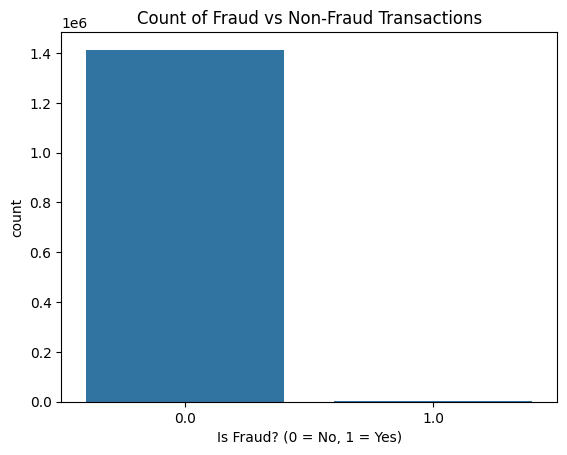

In [17]:
plt.figure()
sns.countplot(x='isFraud', data=df)
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.title('Count of Fraud vs Non‑Fraud Transactions')
plt.show()


In [18]:
# 4.1 Cap amount outliers at the 1st and 99th percentiles
# compute percentiles on the raw amount
p1, p99 = df['amount'].quantile([0.01, 0.99])
print(f"1st pct: {p1:.2f}, 99th pct: {p99:.2f}")

# clip amounts to [p1, p99]
df['amount_clipped'] = df['amount'].clip(lower=p1, upper=p99)


1st pct: 449.59, 99th pct: 1334132.72


In [19]:
# 4.2 Log‑transform the clipped amount
df['log_amount'] = np.log1p(df['amount_clipped'])

# quick check
df[['amount', 'amount_clipped', 'log_amount']].describe().T


,count,mean,std,min,25%,50%,75%,max
amount,1414781.0,162406.627147,269417.940887,0.100000,13195.81000,79337.030000,218518.270000,1.000000e+07
amount_clipped,1414781.0,156214.980578,219486.066365,449.590000,13195.81000,79337.030000,218518.270000,1.334133e+06
log_amount,1414781.0,10.862859,1.778316,6.110558,9.48773,11.281473,12.294629,1.410379e+01


In [20]:
# 4.3 One‑hot encode the 'type' column
type_dummies = pd.get_dummies(df['type'], prefix='type')
df = pd.concat([df, type_dummies], axis=1)

# drop the original column (optional)
df.drop('type', axis=1, inplace=True)

# quick check
df.filter(like='type_').sum().to_frame('counts')


,counts
type_CASH_IN,310330
type_CASH_OUT,506507
type_DEBIT,9298
type_PAYMENT,471499
type_TRANSFER,117147


In [21]:
# 5.1 Balance‐based features
# Difference in balances before vs. after should equal the amount for normal txns
df['orig_balance_diff']   = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_balance_diff']   = df['newbalanceDest'] - df['oldbalanceDest']

# Mismatch: how much the balance change deviates from the amount
df['orig_balance_mismatch'] = df['orig_balance_diff'] - df['amount']
df['dest_balance_mismatch'] = df['dest_balance_diff'] - df['amount']

# Ratio: amount relative to starting balance (add 1 to avoid div‑0)
df['amt_to_org_balance']  = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amt_to_dest_balance'] = df['amount'] / (df['oldbalanceDest'] + 1)


In [22]:
# 5.2 Counterparty‐type feature
# Flag whether the destination is a merchant (IDs starting with 'M')
df['dest_is_merchant'] = df['nameDest'].str.startswith('M').astype(int)


In [23]:
# 5.3 Temporal features from 'step' (hours since start)
# Hour of day (0–23) and day since simulation start
df['hour_of_day'] = df['step'] % 24
df['day_since_start'] = df['step'] // 24


In [24]:
# 5.4 Clean up textual ID columns (optional)
# If you don’t need the raw IDs, drop them to avoid high‑cardinality noise
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [25]:
# 5.5 Quick sanity check: view the new features’ distributions
df[['orig_balance_mismatch', 'amt_to_org_balance',
    'dest_is_merchant', 'hour_of_day']].describe().T


,count,mean,std,min,25%,50%,75%,max
orig_balance_mismatch,1414781.0,-141573.106899,318165.417386,-2.000000e+07,-175975.560000,-25142.700000,-2047.62,0.01
amt_to_org_balance,1414781.0,56881.747125,184953.867932,3.485037e-07,0.204667,6.305765,11954.06,5860862.89
dest_is_merchant,1414781.0,0.333266,0.471381,0.000000e+00,0.000000,0.000000,1.00,1.00
hour_of_day,1414781.0,14.725418,4.358211,0.000000e+00,12.000000,15.000000,18.00,23.00


In [30]:
# Drop rows where the target variable 'isFraud' is NaN
df.dropna(subset=['isFraud'], inplace=True)

# 1. Prepare X & y (drop the target and flag)
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']


# 2. Subsample 200k rows to speed things up, preserving class balance
X_sub, _, y_sub, _ = train_test_split(
    X, y,
    train_size=200_000,
    stratify=y,
    random_state=42
)

# 3. Train/validation split on the subsample
X_train, X_val, y_train, y_val = train_test_split(
    X_sub, y_sub,
    test_size=0.3,
    stratify=y_sub,
    random_state=42
)

# 4. Compute scale_pos_weight for XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"scale_pos_weight = {scale_pos_weight:.1f}")

# 5. Train the baseline XGBoost
model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

scale_pos_weight = 896.4


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:18:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

Top 10 features:
 orig_balance_diff        0.524324
newbalanceOrig           0.150485
amt_to_org_balance       0.111386
hour_of_day              0.069772
newbalanceDest           0.031863
amount                   0.025830
oldbalanceOrg            0.025792
type_PAYMENT             0.016099
type_TRANSFER            0.011156
orig_balance_mismatch    0.009664
dtype: float32


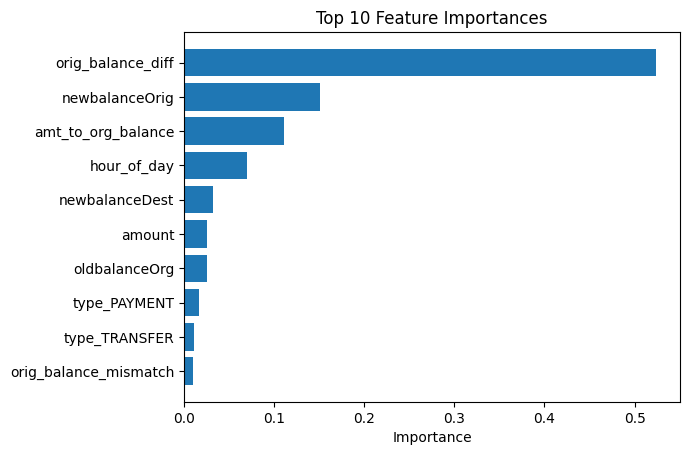

In [28]:

fi = pd.Series(model.feature_importances_, index=X_train.columns)
fi = fi.sort_values(ascending=False)

# 1. Print the top 10 features
print("Top 10 features:\n", fi.head(10))

# 2. (Optional) Visualize
plt.figure()
plt.barh(fi.head(10).index[::-1], fi.head(10).values[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()


In [29]:
# 6.1 Split the full dataset into train/validation
# defining final feature list
FEATURES = [
    'log_amount',
    'orig_balance_diff',
    'amt_to_org_balance',
    'hour_of_day',
    'dest_is_merchant',
    'type_CASH_OUT',
    'type_TRANSFER',
    'newbalanceOrig'
]

X = df[FEATURES]
y = df['isFraud']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)


Train shape: (990346, 8) Valid shape: (424434, 8)


In [35]:
# 6.2 Train the final XGBoost model with class‑weighting
import xgboost as xgb

# calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)

print("Final model trained successfully.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:19:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model trained successfully.


Text(0.5, 1.0, 'Fraudulent Transactions Over Time')

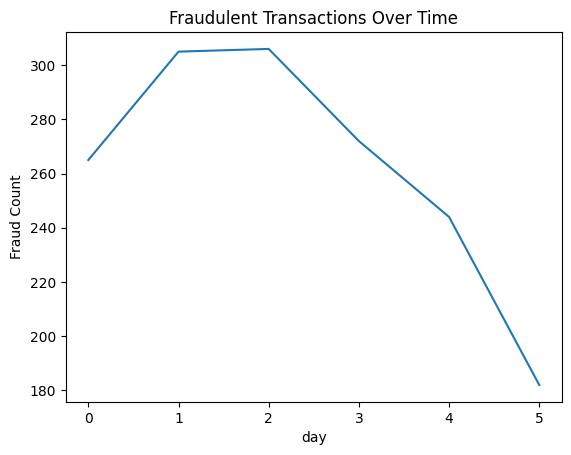

In [36]:
df["day"] = (df["step"] // 24)
daily = df.groupby("day")["isFraud"].sum()
daily.plot()
plt.ylabel("Fraud Count")
plt.title("Fraudulent Transactions Over Time")


In [43]:
# 6.2 Train the final XGBoost model with class‑weighting
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix

# calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Ensure X_train and X_valid have the correct features and convert to numpy arrays
X_train_np = X_train[FEATURES].values
X_valid_np = X_valid[FEATURES].values


model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_np, y_train)

print("Final model trained successfully.")

# 6.3 Evaluate on validation set
# predicted probabilities
y_proba = model.predict_proba(X_valid_np)[:,1]

# overall ROC AUC
roc_auc = roc_auc_score(y_valid, y_proba)
print(f"Validation ROC AUC: {roc_auc:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:21:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model trained successfully.
Validation ROC AUC: 0.9935


In [41]:
# 6.4 Find the best threshold by max F1 on the PR curve
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best threshold by F1: {best_thresh:.4f}, Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")


Best threshold by F1: 0.9963, Precision: 0.8368, Recall: 0.8581, F1: 0.8473


In [42]:
# 6.5 Final classification report & confusion matrix at that threshold
y_pred = (y_proba >= best_thresh).astype(int)

print("Classification Report:")
print(classification_report(y_valid, y_pred, digits=4))

cm = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9998    0.9998    0.9998    423962
         1.0     0.8368    0.8581    0.8473       472

    accuracy                         0.9997    424434
   macro avg     0.9183    0.9289    0.9236    424434
weighted avg     0.9997    0.9997    0.9997    424434

Confusion Matrix:
 [[423883     79]
 [    67    405]]


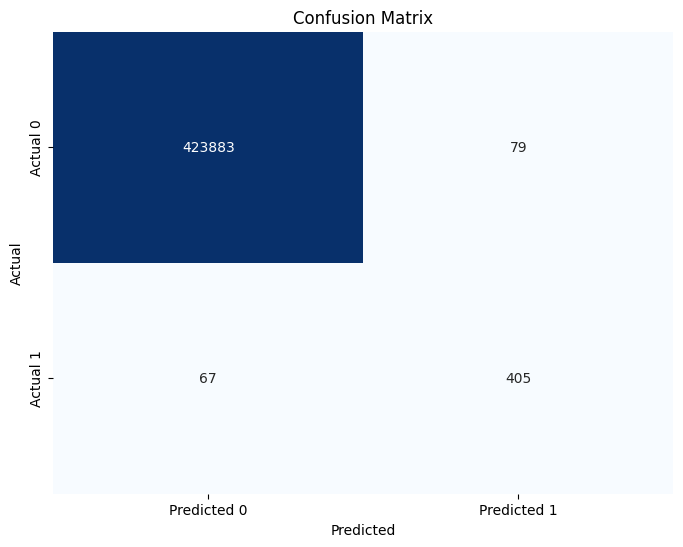

In [53]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Feature Correlation Matrix')

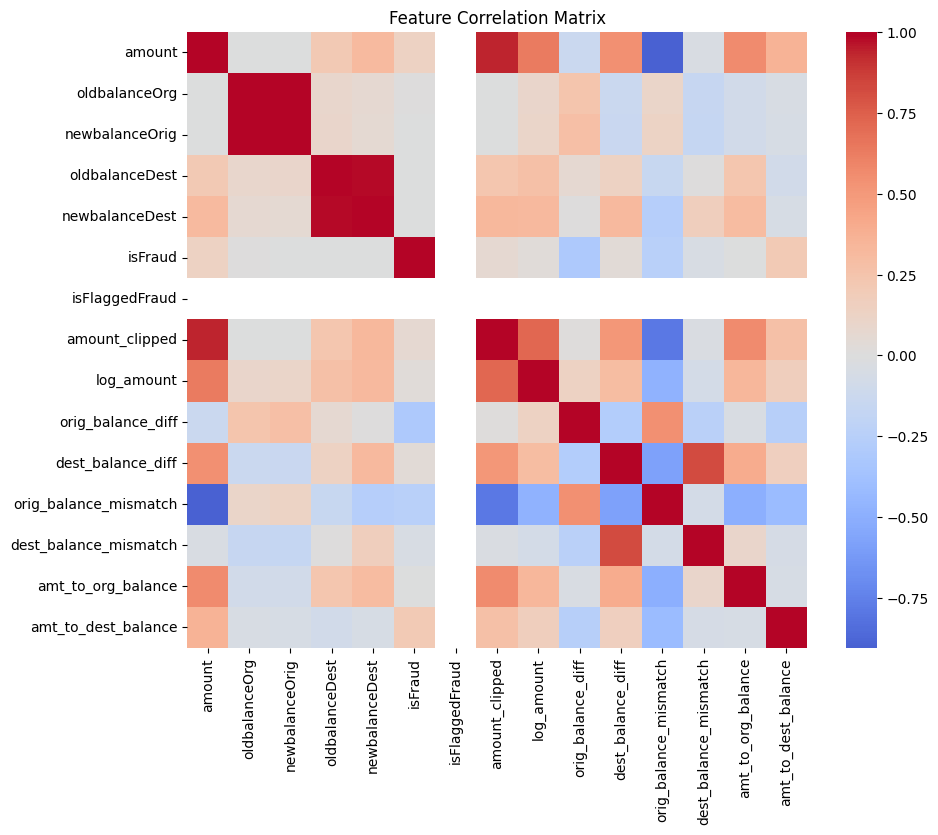

In [44]:
import seaborn as sns
corr = df.select_dtypes(float).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")


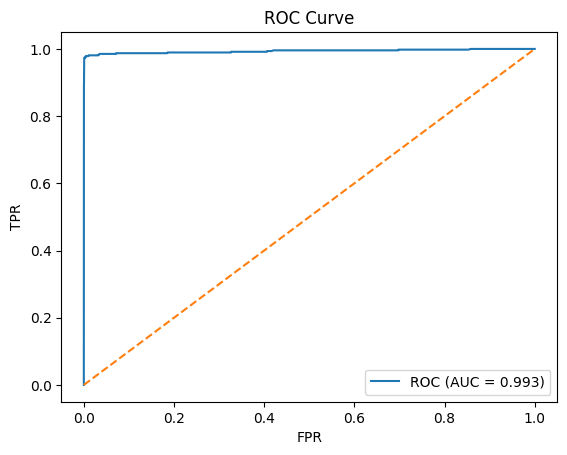

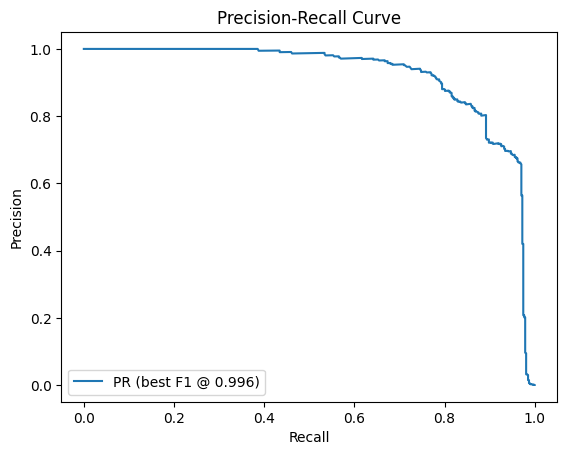

In [45]:
# 6.6 (Optional) Precision‑Recall and ROC curves
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

# PR curve
plt.figure()
plt.plot(recall, precision, label=f"PR (best F1 @ {best_thresh:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Curve')
plt.legend()
plt.show()


In [46]:
import joblib
joblib.dump(model, "xgb_fraud_model.joblib")
print("Saved model to xgb_fraud_model.joblib")


Saved model to xgb_fraud_model.joblib


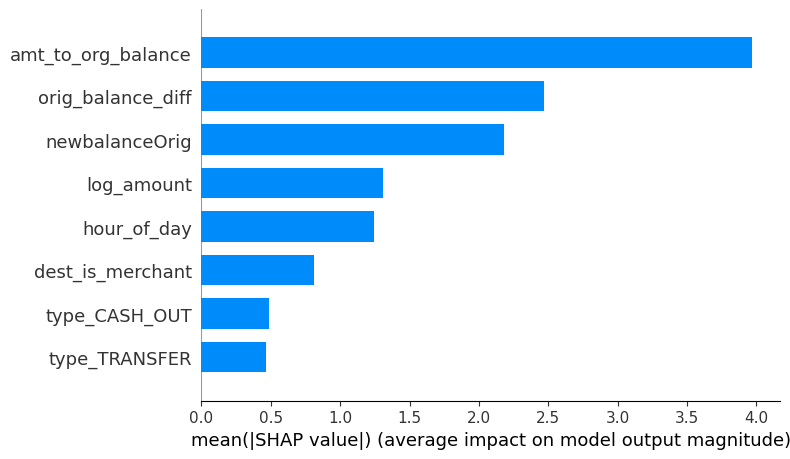

In [47]:
import shap

# 7.1 Create the TreeExplainer
explainer = shap.TreeExplainer(model)

# 7.2 Calculate SHAP values on a sample (for speed)
X_sample = X_valid.sample(n=50_000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 7.3 SHAP summary plot
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    max_display=10
)


In [48]:
pip install fastapi uvicorn confluent-kafka joblib

In [49]:
import uvicorn
from fastapi import FastAPI

In [50]:
import os
print(os.listdir())  # you should now see xgb_fraud_model.joblib


['.config', 'Fraud.csv', 'xgb_fraud_model.joblib', 'sample_data']


In [ ]:
# file: realtime_scoring.py

import os
import json
import time
import joblib
import xgboost as xgb
from fastapi import FastAPI
from pydantic import BaseModel
from confluent_kafka import Consumer, Producer, KafkaError

# 1. Load model & config
MODEL_PATH       = os.getenv("MODEL_PATH", "xgb_fraud_model.joblib")
KAFKA_BOOTSTRAP  = os.getenv("KAFKA_BOOTSTRAP", "kafka:9092")
IN_TOPIC         = os.getenv("IN_TOPIC", "raw-transactions")
OUT_TOPIC        = os.getenv("OUT_TOPIC", "scored-transactions")
THRESHOLD        = float(os.getenv("FRAUD_THRESHOLD", "0.9985"))
BATCH_SIZE       = int(os.getenv("BATCH_SIZE", "50"))
FLUSH_INTERVAL   = int(os.getenv("FLUSH_INTERVAL", "100"))  # flush every N messages

# Load the trained model
model = joblib.load(MODEL_PATH)

# 2. Set up Kafka consumer & producer with batching configs
consumer = Consumer({
    "bootstrap.servers": KAFKA_BOOTSTRAP,
    "group.id": "fraud-scorer",
    "auto.offset.reset": "earliest"
})
producer = Producer({
    "bootstrap.servers": KAFKA_BOOTSTRAP,
    "linger.ms": 50  # allow small batching delay
})
consumer.subscribe([IN_TOPIC])

# 3. Consume, batch, score, produce
message_buffer = []
count = 0

while True:
    msg = consumer.poll(1.0)
    if msg is None:
        continue
    if msg.error():
        if msg.error().code() != KafkaError._PARTITION_EOF:
            print("Kafka error:", msg.error())
        continue

    # parse record and buffer
    record = json.loads(msg.value())
    message_buffer.append(record)

    # process in batches
    if len(message_buffer) >= BATCH_SIZE:
        # extract feature matrix
        features = [
            [
                rec.get("log_amount"),
                rec.get("orig_balance_diff"),
                rec.get("amt_to_org_balance"),
                rec.get("hour_of_day"),
                rec.get("dest_is_merchant"),
                rec.get("type_CASH_OUT"),
                rec.get("type_TRANSFER"),
                rec.get("newbalanceOrig")
            ]
            for rec in message_buffer
        ]
        # batch prediction
        proba_list = model.predict_proba(features)[:, 1]

        # produce scored records
        for rec, proba in zip(message_buffer, proba_list):
            pred = int(proba >= THRESHOLD)
            output = {**rec, "fraud_score": proba, "isFraud_pred": pred}
            producer.produce(OUT_TOPIC, json.dumps(output).encode("utf-8"))
            count += 1
            # periodic flush to improve throughput
            if count % FLUSH_INTERVAL == 0:
                producer.flush(timeout=1.0)

        # clear buffer
        message_buffer.clear()

# Note: flush on shutdown if desired


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel

class Transaction(BaseModel):
    log_amount: float
    orig_balance_diff: float
    …  # all 8 fields

app = FastAPI()

@app.post("/score")
async def score(txn: Transaction):
    features = [txn.log_amount, txn.orig_balance_diff, …]
    proba = await loop.run_in_executor(None, model.predict_proba, [features])
    return {"fraud_score": proba[0][1], "isFraud_pred": int(proba[0][1] >= THRESHOLD)}


In [ ]:
client = TestClient(app)
assert client.get("/health").status_code == 200
assert client.post("/threshold", json={"threshold": 0.95}).json() == {"new_threshold": 0.95}
